In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [26]:
# Define the KNN class
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.to_numpy() 

    def predict(self, X):
        predictions = []
        for x in X:
            distances = self.compute_distance(x, self.X_train)
            k_nearest_neighbors = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_neighbors]
            predictions.append(np.mean(k_nearest_labels))
        return np.array(predictions)

    def compute_distance(self, X1, X2):
        return np.sqrt(np.sum((X1 - X2) ** 2, axis=1))

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    X_train = train_data.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
    y_train = train_data['Exited']
    
    X_test = test_data.drop(['Surname', 'CustomerId'], axis=1)

    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])
    
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, y_train, X_test

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
# Define cross-validation function
def cross_validate(X, y, knn, n_splits=5):
    kf = KFold(n_splits=n_splits)
    auc_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    return np.mean(auc_scores)

Evaluating KNN with k=70, distance_metric=euclidean...
AUC score: 0.9176
Evaluating KNN with k=70, distance_metric=manhattan...
AUC score: 0.9176
Evaluating KNN with k=71, distance_metric=euclidean...
AUC score: 0.9176
Evaluating KNN with k=71, distance_metric=manhattan...
AUC score: 0.9176
Evaluating KNN with k=72, distance_metric=euclidean...
AUC score: 0.9177
Evaluating KNN with k=72, distance_metric=manhattan...
AUC score: 0.9177
Evaluating KNN with k=73, distance_metric=euclidean...
AUC score: 0.9175
Evaluating KNN with k=73, distance_metric=manhattan...
AUC score: 0.9175
Evaluating KNN with k=74, distance_metric=euclidean...
AUC score: 0.9175
Evaluating KNN with k=74, distance_metric=manhattan...
AUC score: 0.9175
Evaluating KNN with k=75, distance_metric=euclidean...
AUC score: 0.9175
Evaluating KNN with k=75, distance_metric=manhattan...
AUC score: 0.9175
Evaluating KNN with k=76, distance_metric=euclidean...
AUC score: 0.9176
Evaluating KNN with k=76, distance_metric=manhattan

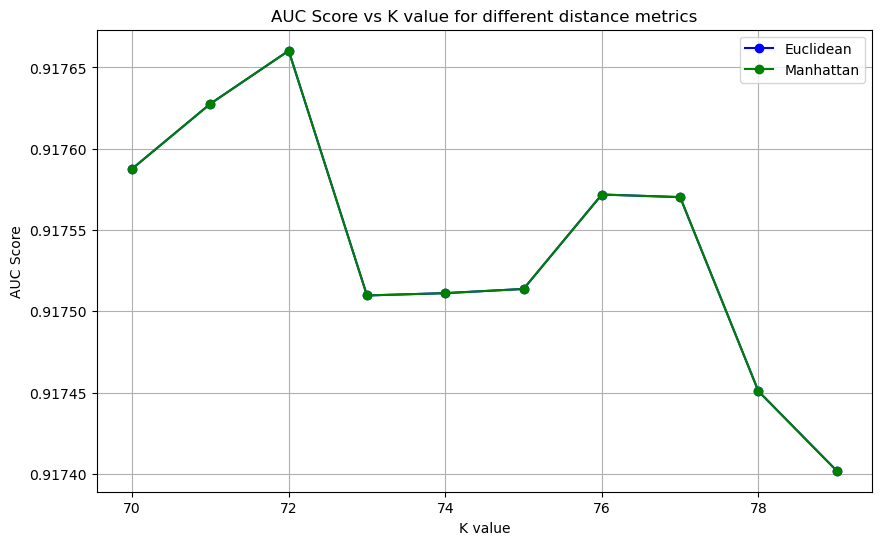

In [29]:
# Load and preprocess data
X, y, X_test = preprocess_data('train.csv', 'test.csv')

# # Create and evaluate model
# knn = KNN(k=5, distance_metric='euclidean')

# # Perform cross-validation
# cv_scores = cross_validate(X, y, knn)

# print("Cross-validation scores:", cv_scores)

# TODO: hyperparamters tuning
def grid_search(X, y, k_values, distance_metrics, n_splits=5):
    best_k = None
    best_distance_metric = None
    best_score = 0
    results = []
    
    for k in k_values:
        for distance_metric in distance_metrics:
            print(f"Evaluating KNN with k={k}, distance_metric={distance_metric}...")
            knn = KNN(k=k, distance_metric=distance_metric)
            auc_score = cross_validate(X, y, knn, n_splits=n_splits)
            results.append((k, distance_metric, auc_score))
            print(f"AUC score: {auc_score:.4f}")
            
            if auc_score > best_score:
                best_k = k
                best_distance_metric = distance_metric
                best_score = auc_score

    print(f"\nBest hyperparameters: k={best_k}, distance_metric={best_distance_metric}, AUC={best_score:.4f}")
    return best_k, best_distance_metric, best_score, results

k_values = range(70, 80) 
distance_metrics = ['euclidean', 'manhattan']
best_k, best_distance_metric, best_score, grid_search_results = grid_search(X, y, k_values, distance_metrics)

for k, metric, score in grid_search_results:
    print(f"k={k}, distance_metric={metric}, AUC={score:.4f}")
def plot_grid_search_results(results):
    euclidean_results = [(k, auc) for k, metric, auc in results if metric == 'euclidean']
    manhattan_results = [(k, auc) for k, metric, auc in results if metric == 'manhattan']
    
    k_values_euclidean = [r[0] for r in euclidean_results]
    auc_values_euclidean = [r[1] for r in euclidean_results]
    
    k_values_manhattan = [r[0] for r in manhattan_results]
    auc_values_manhattan = [r[1] for r in manhattan_results]
    
    plt.figure(figsize=(10, 6))
    
    # AUC vs K for Euclidean and Manhattan
    plt.plot(k_values_euclidean, auc_values_euclidean, marker='o', label='Euclidean', color='blue')
    plt.plot(k_values_manhattan, auc_values_manhattan, marker='o', label='Manhattan', color='green')
    
    plt.xlabel('K value')
    plt.ylabel('AUC Score')
    plt.title('AUC Score vs K value for different distance metrics')
    plt.legend()
    plt.grid(True)
    plt.show()





# TODO: Train on full dataset with optimal hyperparameters and make predictions on test set
knn = KNN(k=72, distance_metric='euclidean') 
knn.fit(X, y)
test_predictions = knn.predict(X_test)

# Save test predictions
pd.DataFrame({'id': pd.read_csv('test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)
print("Prediction results saved to 'submissions.csv'")

plot_grid_search_results(grid_search_results)